# Test modeling on larger synthetic dataset with 300bp
Use 5g sequences but score them simply.

Still try various models
* Linear model
* Kmer count model
* CNN model
* CNN + LSTM model


## ** Classification instead of regression
* overfit first?

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import optuna
from optuna.trial import TrialState

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler


import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G data

In [3]:
locus_info_filename = 'data/locus2info.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237


In [4]:
# add synthetic score column
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

m1 = "CACACA"
m2 = "GTGTGT"

def classify_seqs_motif(seqs):
    data = []
    for locus_tag,seq in seqs:
        seq = seq.strip("N")
        if (m1 in seq and m2 in seq):
            print("both motifs in seq - skipping")
            c = 'skip'
        elif m1 in seq:
            c = 0
        elif m2 in seq:
            c = 1
        else:
            c = 2
        data.append([locus_tag,c])
        
    df = pd.DataFrame(data, columns=['locus_tag','reg'])
    return df

In [5]:
syn_motif_dict = dict(classify_seqs_motif(XYdf[['locus_tag','upstream_region']].values).values)
syn_motif_dict

both motifs in seq - skipping
both motifs in seq - skipping


{'EQU24_RS00005': 2,
 'EQU24_RS00010': 2,
 'EQU24_RS00015': 2,
 'EQU24_RS00025': 2,
 'EQU24_RS00060': 2,
 'EQU24_RS00065': 2,
 'EQU24_RS00080': 2,
 'EQU24_RS00085': 2,
 'EQU24_RS00105': 2,
 'EQU24_RS00110': 2,
 'EQU24_RS00125': 2,
 'EQU24_RS00165': 2,
 'EQU24_RS00175': 2,
 'EQU24_RS00180': 2,
 'EQU24_RS00185': 2,
 'EQU24_RS00195': 2,
 'EQU24_RS00200': 2,
 'EQU24_RS00205': 2,
 'EQU24_RS00210': 2,
 'EQU24_RS00215': 2,
 'EQU24_RS00225': 2,
 'EQU24_RS00230': 2,
 'EQU24_RS00245': 2,
 'EQU24_RS00250': 2,
 'EQU24_RS00255': 2,
 'EQU24_RS00260': 2,
 'EQU24_RS00265': 2,
 'EQU24_RS00270': 2,
 'EQU24_RS00275': 1,
 'EQU24_RS00295': 2,
 'EQU24_RS00300': 2,
 'EQU24_RS00315': 2,
 'EQU24_RS00320': 2,
 'EQU24_RS00330': 2,
 'EQU24_RS00370': 2,
 'EQU24_RS00385': 2,
 'EQU24_RS00390': 2,
 'EQU24_RS00400': 2,
 'EQU24_RS00405': 2,
 'EQU24_RS00425': 2,
 'EQU24_RS00455': 2,
 'EQU24_RS00470': 2,
 'EQU24_RS00475': 2,
 'EQU24_RS00480': 2,
 'EQU24_RS00490': 2,
 'EQU24_RS00495': 2,
 'EQU24_RS00500': 2,
 'EQU24_RS005

In [6]:
XYdf['reg'] = XYdf['locus_tag'].apply(lambda x: syn_motif_dict[x])
XYdf = XYdf[XYdf['reg'] != 'skip']
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,reg
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.230893,-0.311506,-0.524588,-0.926510,0.0,0.018495,0.109974,-0.045442,0.546757,-0.468551,-0.322610,-0.407143,2
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.008729,-0.466359,-0.830462,-1.656433,0.0,0.124663,0.407828,0.037725,0.731449,-0.449818,-0.512788,-0.448725,2
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.263911,-0.048943,-0.612371,-0.615279,0.0,0.057550,0.246420,0.028300,0.666104,-0.404861,-0.453445,-0.286782,2
3,4,EQU24_RS00025,GATGGGCGACATCGTCGAACCGCGCCGGGATTTCATCGTCAAGAAT...,-0.034904,-0.574712,-0.655377,-1.555096,0.0,-0.032478,-0.034485,0.032271,0.643267,-0.257761,-0.540832,-0.234343,2
4,11,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.002609,0.003625,-1.075138,-1.341292,0.0,-0.076037,0.095018,-0.064943,-0.476696,-0.238368,0.268194,0.339613,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199,4203,EQU24_RS22110,GAAGACTGCTCGGTTTGCTGTTCTCCTATTTACGTACAAATCGAAG...,0.041825,0.199584,-0.158523,-2.684471,0.0,-0.492002,-0.037340,-0.221623,-1.266702,-0.361081,-1.081770,-0.714619,2
2200,4204,EQU24_RS22115,AGCGCACCGCTATCGCTCTGGCTTAGATATCAAATCATTCGGCTAA...,0.016197,-0.676160,-1.230196,-1.462699,0.0,0.029478,0.183147,0.010712,-0.086861,-0.712912,-1.430957,-1.390777,2
2201,4206,EQU24_RS22125,ACTGGTACGACAGCGAAACAATTTTAAAGAAATAGCACGACACGTT...,0.052273,-0.478136,-1.134588,-0.772442,0.0,-0.344101,0.053862,-0.268642,-0.258241,-0.916986,0.147953,0.006596,2
2202,4207,EQU24_RS22130,GAAAATAACCCGCGAATTAACACCAAACCGAGACCCAAACAACAAA...,-0.150132,-0.534905,-0.811117,-0.723198,0.0,-0.072452,-0.199881,-0.117306,0.142879,-0.388531,0.209171,0.320237,2


In [7]:
loc2seq = dict([(x,z) for (x,z) in XYdf[['locus_tag','upstream_region']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])

{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGGTTATTTTTTGGCATTGCTATGATCGAAATGGAATGAAAATGATCCGAAAAACAGGCTTTTGTAAGCAACCGATAAATAAGAGGTTAAGGGCTGGAAGATAAATGAAAATCAGGGTGGATAAAGAACTAATGATTAATAGCGCACTAGATCGGTCATAAATTAAGTTGACAAGCCTTTTCGAAATGATAAACTGAGCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA


In [8]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,id_col='locus_tag',val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,val_df,test_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=[id_col,'set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"Distribution")
    plt.show()

## Load 5G seqs into data loaders

In [9]:
dataset_types = [
    DatasetSpec('ohe'),
    DatasetSpec('kmer',k=3),
    DatasetSpec('kmer',k=6),
]

In [10]:
full_train_df,test_df = tu.quick_split(XYdf)
train_df, val_df = tu.quick_split(full_train_df)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    seq_col='upstream_region',
    target_col='reg'
)

kmer6_train_dl,kmer6_val_dl = dls['kmer_6']
kmer3_train_dl,kmer3_val_dl = dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

In [11]:
for i in ohe_train_dl:
    print(i[1].shape)
    break

torch.Size([128, 1])


In [12]:
print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(1761, 17)
(441, 17)
(1408, 18)
(353, 18)


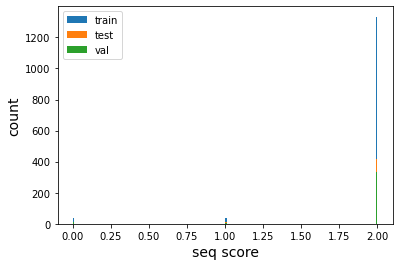

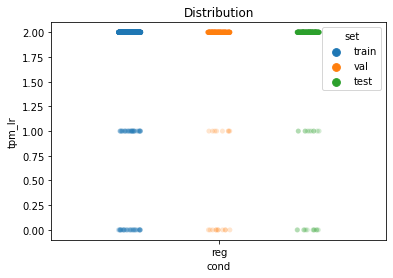

In [13]:
plot_train_test_hist(train_df, test_df, val_df=val_df,score_col='reg',bins=200)
view_train_test_dist(train_df, test_df,["reg"],val_df=val_df)

In [14]:
train_df['reg'].values

array([2, 2, 2, ..., 2, 2, 2], dtype=object)

In [17]:
seqs = train_df['upstream_region'].values

print("CACACA:",len([x for x in seqs if m1 in x]))
print("GTGTGT:",len([x for x in seqs if m2 in x]))

print("NO CACACA:",len([x for x in seqs if m1 not in x]))
print("NO GTGTGT:",len([x for x in seqs if m2 not in x]))

print("BOTH:",len([x for x in seqs if (m2 in x and m1 in x)]))
print("NEITHER:",len([x for x in seqs if (m2 not in x and m1 not in x)]))

CACACA: 36
GTGTGT: 39
NO CACACA: 1372
NO GTGTGT: 1369
BOTH: 0
NEITHER: 1333


## Non-optuna training

In [30]:
def quick_seq_pred(model, seqs, oracle):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
        pred = model(s.float())
        actual = oracle[dna]
        diff = actual - pred.item()
        print(f"{dna}: pred:{pred.item():.3f} actual:{actual:.3f} ({diff:.3f})")

    
def loss_batch(model, loss_func, xb, yb, opt=None,verbose=True):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    xb_out = model(xb.float())
    if verbose:
        print("model out pre loss", xb_out.shape)
    #loss = loss_func(xb_out, yb.float())
    loss = loss_func(xb_out, yb.squeeze(1))

    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)

def train_step(model, train_dl, loss_func, opt):
    '''
    Execute 1 set of batch training for an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    # collect train loss; provide opt so backpropo happens
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(DEVICE),yb.to(DEVICE)

        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)
        tl.append(t)
        ns.append(n)
        
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    return train_loss

def val_step(model, val_dl, loss_func):
    '''
    Execute 1 set of batch validation for an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(DEVICE),yb.to(DEVICE)

            v, n = loss_batch(model, loss_func, xb, yb)
            vl.append(v)
            ns.append(n)

    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        train_loss = train_step(model, train_dl, loss_func, opt)
        train_losses.append(train_loss)
        
        
        val_loss = val_step(model, val_dl, loss_func)
        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

def run_model(train_dl,test_dl, model, lr=0.01, epochs=20):
    '''
    Given data and a model type, run dataloaders with MSE loss and SGD opt
    '''
    # define loss func and optimizer
    #loss_func = torch.nn.MSELoss() 
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) 
    
    # run the training loop
    train_losses, test_losses = fit(epochs, model, loss_func, optimizer, train_dl, test_dl)
    
    #return model, train_losses, test_losses
    return train_losses, test_losses

In [26]:
class DNA_Linear_Deep(nn.Module):
    def __init__(
        self, 
        seq_len,
        h0_size=24,
        h1_size=24
    ):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h0_size, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.Softmax()
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Softmax()
            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        #xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

class Kmer_Linear(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin = nn.Sequential(
            nn.Linear(num_kmers, h1_size), ## TODO: Can this be combined? Bring num_kmers outside?
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True),
            nn.Linear(h2_size, 1),
        )
        
        
    def forward(self, xb):
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out

In [20]:
def parity_plot_multi(model,df, pearson):
    #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    sns.scatterplot(data=df,y='pred',x='truth',hue='task',alpha=0.2)
    #draw y=x line
    xpoints = ypoints = plt.xlim()
    plt.plot(xpoints, ypoints, color='k', lw=1, scalex=False, scaley=False)

    plt.ylim(xpoints)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.xlabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    
    plt.show()

def alt_parity_plot_multi(model,df, pearson,task):
    '''
    Make an interactive parity plot with altair
    '''
    chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
        alt.Y('pred:Q'),
        alt.X('truth:Q'),
        tooltip=['seq:N']
    ).properties(
        title=f'Model (pearson:{pearson})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{task}_{model}.html')
    
    
def parity_pred_multi(models, genes, oracle,task,objs,alt=True,syn_data=False):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: (pearson corr, parity_df)
    
    
    for model_name,model,ds in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            if ds.name == 'ohe':
                s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0).to(DEVICE)
            elif ds.name == 'kmer':
                s = torch.tensor(u.count_kmers_in_seq(dna,u.kmers(ds.k))).to(DEVICE)
                # need unsqueeze?
            else:
                raise ValueError(f"Unknown DataSetSpec Type {ds.name}. Currently just [ohe, kmer]")

            actual = oracle[gene]
            preds = [x.item() for x in model(s.float())]

            for i in range(len(preds)):
                data.append((gene,actual[i], preds[i],objs[i],dna))

        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','task','seq'])
        pearson = df['truth'].corr(df['pred'])
        
        if not syn_data: # if using real genes, add real gene info
            df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
            df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])
            df['type'] = df['locus_tag'].apply(lambda x: locus2info[x]['type'])
        
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
        parity_plot_multi(model_name, df, pearson)

    return dfs

In [21]:
class TINKER_DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters0=32,
                 num_filters1=32,
                 kernel_size0=8,
                 kernel_size1=8,
                 conv_pool_size0=1,
                 conv_pool_size1=1,
                 fc_node_num0 = 100,
                 fc_node_num1 = 100
                ):
        super().__init__()
        
        self.seq_len = seq_len
        #self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        linear_node_num = int(np.floor((seq_len - kernel_size0 + 1)/conv_pool_size0))
        linear_node_num = int(np.floor((linear_node_num - kernel_size1 + 1)/conv_pool_size1))
        linear_node_num = linear_node_num*num_filters1


        
        self.conv_net = nn.Sequential(
            # Conv layer 0
            nn.Conv2d(1, num_filters0, kernel_size=(4,kernel_size0)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),

            # Conv layer 1
            nn.Conv2d(num_filters0, num_filters1, kernel_size=(1,kernel_size1)),
            nn.ReLU(),
            
            nn.Flatten(),
            # Fully connected layer 0
            nn.Linear(linear_node_num, fc_node_num0),
            nn.ReLU(),
            # Fully connected layer 0
            nn.Linear(fc_node_num0, fc_node_num1),
            nn.ReLU(),
            # final prediction
            nn.Linear(fc_node_num1, 1),
            nn.Softmax()
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        
        #xb = xb.permute(0,2,1) 
        # OHE FIX??
        
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        
        out = self.conv_net(xb)
        return out

### Deep linear

In [31]:
seq_len = len(train_df['upstream_region'].values[0])

mer8motif_model_lin_d = DNA_Linear_Deep(
    seq_len,
    h0_size=100,
    h1_size=100,
)
mer8motif_model_lin_d.to(DEVICE)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_lin_d,
    lr=0.01,
    epochs=100
)

# to plot loss
mer8motif_lin_d_data_label = [((mer8motif_train_losses_lin_d,mer8motif_test_losses_lin_d),"Lin(dp)")]

tu.quick_loss_plot(mer8motif_lin_d_data_label)

loss batch ****
xb shape: torch.Size([128, 300, 4])
yb shape: torch.Size([128, 1])
yb shape: torch.Size([128])
model out pre loss torch.Size([128, 1])


RuntimeError: CUDA error: device-side assert triggered

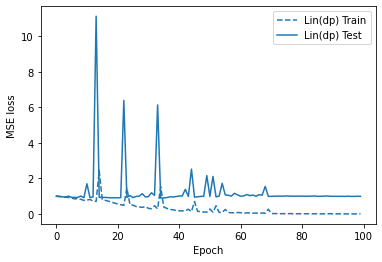

DNA_Linear_Deep(
  (lin): Sequential(
    (0): Linear(in_features=1200, out_features=10000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10000, out_features=10000, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=10000, out_features=1, bias=True)
  )
)

In [41]:
tu.quick_loss_plot(mer8motif_lin_d_data_label)

mer8motif_model_lin_d

### CNN model

In [51]:
ohe_train_dl

In [55]:
seq_len = len(train_df['upstream_region'].values[0])
mer8motif_model_cnn = TINKER_DNA_CNN(
    seq_len,
    fc_node_num0=100,
    fc_node_num1=100
)
mer8motif_model_cnn.to(DEVICE)

mer8motif_train_losses_cnn, \
mer8motif_test_losses_cnn = run_model(
    ohe_train_dl, 
    ohe_val_dl, 
    mer8motif_model_cnn, 
    lr=0.01,
    epochs=100,
)

# to plot loss
mer8motif_cnn_data_label = [((mer8motif_train_losses_cnn,mer8motif_test_losses_cnn),'CNN')]


0 0.9829894056063536
1 0.9824649139436716
2 0.9822141695292745
3 0.9819569089595049
4 0.981650932483565
5 0.9812893026611285
6 0.9810262771571324
7 0.9807518315382787
8 0.9804210605432224
9 0.9808847129176088
10 0.980127107151507
11 0.9795335536300291
12 0.9791599032561434
13 0.9785440115010097
14 0.9782282867107446
15 0.9775979334842044
16 1.0304629402525365
17 0.9851718391304989
18 0.9814679614207562
19 1.0257285122493172
20 0.9875288431772767
21 0.9809451358176493
22 0.9795280943173524
23 0.9790339047780455
24 0.9785842106970444
25 0.9783964177366694
26 0.9778030335734316
27 0.977255714176059
28 0.9767584324558464
29 0.9769265903291892
30 0.9763838457993678
31 0.9755734612178533
32 1.0188015805763158
33 0.9840790242716544
34 1.005235873605982
35 0.9805004101974768
36 1.020866400797036
37 0.9792628816774817
38 0.9739996198216512
39 1.0414101810698468
40 0.9734321857984614
41 0.9726667471715479
42 0.9707763725232132
43 0.9700397280052768
44 0.9688081619759795
45 0.967266007118117
46 0

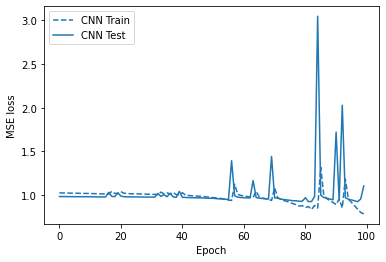

TINKER_DNA_CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=9376, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=100, bias=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [56]:
tu.quick_loss_plot(mer8motif_cnn_data_label)

mer8motif_model_cnn

Running LinearDeep


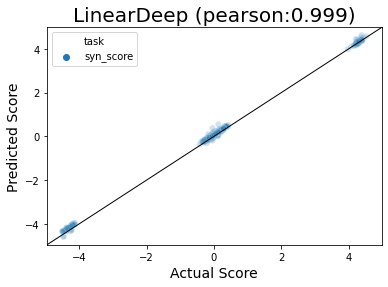

Running CNN


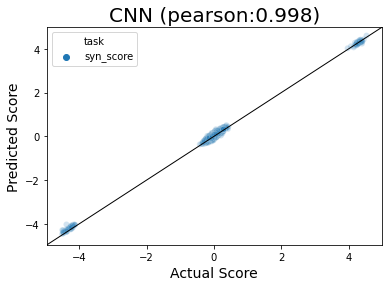

In [43]:
models = [
    ("LinearDeep",mer8motif_model_lin_d,DatasetSpec('ohe')),
    ("CNN",mer8motif_model_cnn,DatasetSpec('ohe')),
#     ("Kmer1_8mer",mer8motif_model_kmer1,DatasetSpec('kmer',k=1)),
#     ("Kmer3_8mer",mer8motif_model_kmer3,DatasetSpec('kmer',k=3)),
]


seqs = train_df['locus_tag'].values #val_df['locus_tag'].values
task = "6mer_motif"

oracle_syn = dict([(a,[b]) for a,b in XYdf[['locus_tag','syn_score']].values])


dfs = parity_pred_multi(models, seqs, oracle_syn,task,['syn_score'],alt=False)